In [1]:
%load_ext autoreload
%autoreload 2

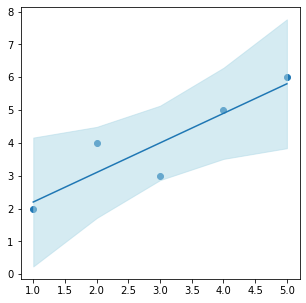

In [9]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def binary_ci(success: int, total: int, alpha: float = 0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, diameter


def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, loc - lower

plt.rcParams["figure.figsize"] = (5,5)

def plot_scatter_with_ci(ax, x, y, show_line=False, scatter_kwargs=dict(), line_kwargs=dict(), ci_kwargs=dict()):
    """
    Procedure to print a scatterplot of points with an appropriate CI shaded area for the correlation.
    """
    
    # sort by x
    x, y = zip(*sorted((xi, yi) for xi, yi in zip(x, y)))

    # calculate_predictions
    d = sm.add_constant(x)
    ols_model = sm.OLS(y, d)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)
    pred = est.get_prediction(d).summary_frame()
    
    ax.scatter(x, y, **scatter_kwargs)
    if show_line:
        ax.plot(x, pred['mean'], **line_kwargs) 
    ax.fill_between(x, pred['mean_ci_lower'], pred['mean_ci_upper'], **ci_kwargs)

plot_scatter_with_ci(
    plt,
    x=[1,2,3,4,5],
    y=[2,4,3,5,6],
    show_line=True,
    ci_kwargs={'alpha': 0.5, 'color': 'lightblue'}
)

In [ ]:
from dataset import get_dataset_by_name
from score import stereo_score
from util import model_init

In [ ]:
model, tokenizer = model_init('roberta-base')
model = model.to('cuda:0')

In [ ]:
dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
ss_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)


In [ ]:
dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
ss_gender_filter = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [ ]:
dt = get_dataset_by_name('stereoset-race-control', tokenizer)
ss_race = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [ ]:
dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
ss_profession = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [ ]:
model, tokenizer = model_init('gerulata/slovakbert')
model = model.to('cuda:0')
dt = get_dataset_by_name('our', tokenizer)
our_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import random

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*ss_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*ss_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*ss_gender_filter)
ax[0].scatter(*ss_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*ss_race)
ax[1].set_title('StereoSet race')
# ax[1].set_xlabel('Original group')
# ax[1].set_ylabel('Control group')
ids = random.sample(range(len(ss_race[0])), k=500 )
ax[1].scatter([ss_race[0][i] for i in ids], [ss_race[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(ss_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*ss_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('StereoSet profession')
ids = random.sample(range(len(ss_profession[0])), k=500 )
ax[2].scatter([ss_profession[0][i] for i in ids], [ss_profession[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(ss_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*our_gender)
ax[3].set_xlabel('Original group')
# ax[3].set_ylabel('Control group')
ax[3].set_title('Slovak gender')
ax[3].scatter(*our_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()

plt.savefig('1.pdf')

In [ ]:
import scipy.stats
import numpy as np
import math

from tokenization import kw_len
from score import our_score

def line_calculations(model, tokenizer, dt):
    
    ss_score = stereo_score(dt, tokenizer, model)
    ss_swap_score = stereo_score(dt, tokenizer, model, swap=True)
    

    # ssmu original
    yield bootstrap_ci(ss_score)
    
    # ssmu control
    yield bootstrap_ci(ss_swap_score)
    
    # ss+ original
    yield binary_ci([ss > 0 for ss in ss_score])
    
    # ss+ control
    yield binary_ci([ss > 0 for ss in ss_swap_score])
    
    # ss pearson
    yield scipy.stats.pearsonr(ss_score, ss_swap_score)
    
    # false positive rate
    yield sum(ss > 0 and ss_swap > ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss > 0 for ss in ss_score)
    
    # false negative rate
    yield sum(ss < 0 and ss_swap < ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss < 0 for ss in ss_score)


In [ ]:
row_names = ['$ss\\mu$ Original', '$ss\\mu$ Control', '$ss+$ Original', '$ss+$ Control', '$ss\\ \\rho$', 'False Positive Rate', 'False Negative Rate']

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'albert-xxlarge-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    lines = [
        line_calculations(model, tokenizer, dt)
        for dt in [
            get_dataset_by_name('stereoset-genderswap', tokenizer),
            get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
            get_dataset_by_name('stereoset-race-control', tokenizer),
            get_dataset_by_name('stereoset-profession-control', tokenizer),
        ]
    ]
    for row, txt in zip(zip(*lines), row_names):
        print(txt, end='')
        for cell in row:
            if isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ss\\mu$ Control', '$ss+$ Control']:
            print('\\\\ \\midline')    
        else:
            print('\\\\')
        

In [ ]:
lines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    dt = get_dataset_by_name('our', tokenizer)
    lines.append(line_calculations(model, tokenizer, dt))

In [ ]:
for row, txt in zip(zip(*lines), row_names):
    print(txt, end='')
    for cell in row:
        if isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$ss\\mu$ Control', '$ss+$ Control']:
        print('\\\\ \\midline')    
    else:
        print('\\\\')

In [ ]:
model, tokenizer = model_init('roberta-base')

In [ ]:
from score import crows_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
cs_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
cs_gender_filter = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-negation', tokenizer)
cs_neg = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-antistereotypes', tokenizer)
cs_anti = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)



In [ ]:
model, tokenizer = model_init('gerulata/slovakbert')
dt = get_dataset_by_name('our', tokenizer)
cs_our_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*cs_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original pair')
ax[0].set_ylabel('Control pair')
ax[0].scatter(*cs_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*cs_gender_filter)
ax[0].scatter(*cs_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
# ax[0].plot([min(cs_gender_filter[0]), max(cs_gender_filter[0])], [min(cs_gender_filter[0]), max(cs_gender_filter[0])], linestyle=':', c='black')
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*cs_neg)
ax[1].set_title('CrowS Negation')
# ax[1].set_xlabel('Original pair')
ax[1].set_ylabel('Control pair')
ax[1].scatter(cs_neg[0][:100], cs_neg[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(cs_neg[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*cs_anti)
ax[2].set_xlabel('Original pair')
ax[2].set_ylabel('Control pair')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(cs_anti[0][:100], cs_anti[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(cs_anti[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')

pred = get_ci_pred(*cs_our_gender)
ax[3].set_xlabel('Original pair')
# ax[3].set_ylabel('Control pair')
ax[3].set_title('Slovak gender')
ax[3].scatter(cs_our_gender[0][:100], cs_our_gender[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(cs_our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()
plt.savefig('2.pdf')

In [ ]:
import scipy.stats
import numpy as np
import math
from score import pair_score, crows_score, our_score

from tokenization import kw_len

def rep(score):
    return (np.mean(score), 2.58 * np.std(score) / math.sqrt(len(score)))

def cs_line_calculations(model, tokenizer, dt):
    
    cs_score = crows_score(dt, tokenizer, model)
    cs_swap_score = crows_score(dt, tokenizer, model, swap=True)
    cs_pair_score = pair_score(dt, tokenizer, model)
    cs_pair_swap_score = pair_score(dt, tokenizer, model, swap=True)
    
    cs_positive = sum(ss > 0 for ss in cs_score) / len(dt)
    cs_swap_positive = sum(ss > 0 for ss in cs_swap_score) / len(dt)
    
    cs_rho = scipy.stats.pearsonr(cs_score, cs_swap_score)[0]
    try:
        cs_pair_rho = scipy.stats.pearsonr(cs_pair_score, cs_pair_swap_score)[0]
        pair_rho = scipy.stats.pearsonr(cs_score, cs_pair_score)[0]
        our = our_score(dt, tokenizer, model)
        agr = sum((o > 0 and s > 0) or (o < 0 and s < 0) for o, s in zip(our, cs_score)) / len(dt)
    except:
        cs_pair_rho = None
        pair_rho = None
        our = None
        agr = None
    
    # 99% CI
    return (rep(cs_score), rep(cs_swap_score), rep(cs_pair_score), rep(cs_pair_swap_score), cs_positive, cs_swap_positive,
        cs_rho, cs_pair_rho, pair_rho,
        agr
    )
            

In [ ]:

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    cslines = []

    for dt in [
        get_dataset_by_name('stereoset-genderswap', tokenizer),
        get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
        get_dataset_by_name('crows-negation', tokenizer),
        get_dataset_by_name('crows-antistereotypes', tokenizer),
    ]:
        cslines.append(cs_line_calculations(model, tokenizer, dt))
    for row, txt in zip(zip(*cslines), ['$csm$ Original', '$csm$ Control', '$csk$ Original', '$csk$ Control', '$csp$ Original', '$csp$ Control', '\\rho', '\\rho', '\\rho', '$f$ agr']):
        print(txt, end='')
        for cell in row:
            if cell is None:
                print(' & ', end='')
            elif isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ssm$ Control', '$ssp$ Control']:
            print('\\\\ \\hline')    
        else:
            print('\\\\')
        

In [ ]:
cslines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    for dt in [
        get_dataset_by_name('our', tokenizer),
    ]:
        cslines.append(cs_line_calculations(model, tokenizer, dt))

In [ ]:

for row, txt in zip(zip(*cslines), ['$csm$ Original', '$csm$ Control', '$csk$ Original', '$csk$ Control', '$csp$ Original', '$csp$ Control', '\\rho', '\\rho', '\\rho', '$f$ agr']):
    print(txt, end='')
    for cell in row:
        if cell is None:
            print(' & ', end='')
        elif isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$ssm$ Control', '$ssp$ Control']:
        print('\\\\ \\hline')    
    else:
        print('\\\\')

In [ ]:
from score import pair_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
css_gender = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
css_gender_filter = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-race-control', tokenizer)
css_race = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
css_profession = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20,5)

fig, ax = plt.subplots(1, 4)

pred = get_ci_pred(*css_gender)
ax[0].set_title('StereoSet gender')
ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*css_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*css_gender_filter)
ax[0].scatter(*css_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].plot([min(css_gender_filter[0]), max(css_gender_filter[0])], [min(css_gender_filter[0]), max(css_gender_filter[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_race)
ax[1].set_title('CrowS Negated')
ax[1].set_xlabel('Original group')
ax[1].set_ylabel('Control group')
ax[1].scatter(css_race[0][:100], css_race[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(css_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].plot([min(css_race[0]), max(css_race[0])], [min(css_race[0]), max(css_race[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(css_profession[0][:100], css_profession[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(css_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].plot([min(css_profession[0]), max(css_profession[0])], [min(css_profession[0]), max(css_profession[0])], linestyle=':', c='black')


plt.savefig('3.pdf')

In [ ]:
import scipy.stats
import numpy as np
import math

from tokenization import kw_len
from score import our_score

def line_calculations(model, tokenizer, dt):
    
    ss_score = stereo_score(dt, tokenizer, model)
    our = our_score(dt, tokenizer, model)
    agr = sum((o > 0 and s > 0) or (o < 0 and s < 0) for o, s in zip(our, ss_score)) / len(dt)
    
    # 99% CI
    return (
        (np.mean(ss_score), 2.58 * np.std(ss_score) / math.sqrt(len(ss_score))),
        (np.mean(ss_swap_score), 2.58 * np.std(ss_swap_score) / math.sqrt(len(ss_swap_score))),
        ss_positive, ss_swap_positive, pearsonr[0], false_positive_rate, false_negative_rate,
        (np.mean(our), 2.58 * np.std(our) / math.sqrt(len(our))), agr
    )
            

In [ ]:

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'albert-xxlarge-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    lines = [
        line_calculations(model, tokenizer, dt)
        for dt in [
            get_dataset_by_name('stereoset-genderswap', tokenizer),
            get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
            get_dataset_by_name('stereoset-race-control', tokenizer),
            get_dataset_by_name('stereoset-profession-control', tokenizer),
        ]
    ]
    for row, txt in zip(zip(*lines), ['$ssm$ Original', '$ssm$ Control', '$ssp$ Original', '$ssp$ Control', '$ss\\ \\rho$', 'False Positive Rate', 'False Negative Rate', '$f$', '$f$ agr']):
        print(txt, end='')
        for cell in row:
            if isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ssm$ Control', '$ssp$ Control']:
            print('\\\\ \\hline')    
        else:
            print('\\\\')
        